---
**License**

 NumCosmoCCLTest

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 NumCosmoCCLTest\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# The power spectrum

This notebook calculates moving distance using the Numcosmo and CCL libraries, and then it compares the results between themselves, plotting the compare and the relative distance of their results in graphics.


## Loading NumCosmo and CCL

The first step is to load both NumCosmo and CCL libraries. We also load some Python packages.

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


### Initializing the NumCosmo library:

In [2]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

### The function of building comparison graphics:
Assembles two comparison graphs, where the graph above presents the result curves of both libraries, while the graph below presents the difference relative distance curve between the results found using the same values in the abscissas axis.                                                                                               

In [3]:
import pylab as plt
def compare(x, y_ccl, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(12, 6)}, xscale = 'linear', yscale = 'log'):
    ccl_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    
    x     = np.array (x)
    y_ccl = np.array (y_ccl)
    y_nc  = np.array (y_nc)
    diff  = np.zeros_like (y_ccl)
    
    non_zind = np.where (y_ccl != 0.0)[0]
    zind     = np.where (y_ccl == 0.0)[0]
    diff[non_zind] = y_nc[non_zind]/y_ccl[non_zind] - 1.0
    diff[zind]     = y_nc[zind] - y_ccl[zind]
    print('[%10s]: rel diff min: %e\trel diff max: %e'%(y_name, min(abs(diff)), max(abs(diff))))
        
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_ccl, label='ccl', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    
    axs[1].plot(x, np.abs (diff), c='r')
    axs[1].set_xscale (xscale)
    axs[1].set_yscale (yscale)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, ccl_name))
    
    return fig, axs

### The fixed cosmological parameters using the cosmology object:

* The cold dark matter density fraction $\Omega_c$ ;
* The baryonic matter density fraction $\Omega_b$ ;
* The hubble constant divided by 100 km/s/Mpc and unitless $h$ ;
* The effective number of massless neutrinos present $N_{\nu}$ ;
* The primordial scalar perturbation spectral index $n_s$ ;
* The power spectrum normalization $A_s$ ;
* The first order term of dark energy equation of state $w_0$ ;

* The second order term of dark energy equation of state $w_a$;


In [4]:
Omega_c = 0.25   # The cold dark matter density fraction.

Omega_b = 0.05   # The baryonic matter density fraction.
        
h       = 0.7    # The hubble constant divided by 100 km/s/Mpc; unitless.

A_s     = 2.1e-9 # The power spectrum normalization.

n_s     = 0.96   # The primordial scalar perturbation spectral index.

Neff    = 0.0    # The effective number of massless neutrinos present.

w0 = -1.0        # The first order term of dark energy equation of state.

wa = 0.0         # The second order term of dark energy equation of state.

### Function compare power spectrum
The below function compares the power spectrum calculation performed by both libraries and buils comparison graphics, it use the following parameters:

 * The redshift between $0.0$ to $1.0$ $z$;
 
 * The wavenumbe with 10000 wavenumber points between $10^{-3}$ to $10$ per Mpc. $k$;
 

In [5]:
def compare_ps (k, z):
    """
    Compare the linear power spectrum.
    """

    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h * 100)
    cosmo.param_set_by_name ("Omegak",    0.0)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
    
    # Set Omega_K in a consistent way
    Omega_k = cosmo.Omega_k0 ()
    Omega_v = cosmo.E2Omega_de (0.0)
    T_CMB   = cosmo.T_gamma0 ()

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0, sigma8 = 0.8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear')

    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    tf_eh = Nc.TransferFuncEH.new ()
    tf_eh.props.CCL_comp = True
    ps_eh = Nc.PowspecMLTransfer.new (tf_eh)
    ps_eh.prepare (cosmo)
    
    fact = (0.8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))**2
    
    #fact = ccl.linear_matter_power (ccl_cosmo, 1.0e-1, 1.0) / ps_eh.eval (cosmo, 0.0, 1.0e-1)      <<---    ??????????
    
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s * fact))
    
    k_min = 1.0e-3
    k_max = 1.0e1
    
    z_min = 0.0
    z_max = 1.0

    ps_eh.set_kmin (k_min)
    ps_eh.set_kmax (k_max)
    ps_eh.require_zi (z_min)
    ps_eh.require_zf (z_max)

    ps_eh.prepare (cosmo)
    
    a = 1.0 / (1.0 + z)
    
    pk_ccl = ccl.linear_matter_power (ccl_cosmo, k, a)
    pk_nc  = [ps_eh.eval (cosmo, z, k_i) for k_i in k]
    compare (k, pk_ccl, pk_nc, x_name = 'k', y_name = 'P_k(%f)' % z, xscale = 'log')    


#### Gets redshift and wavenumbers points

In [6]:
k = np.geomspace (1.0e-3, 1.0e1, 10000)

z = [0.0, 0.5, 1.0]

[P_k(0.000000)]: rel diff min: 5.470260e-04	rel diff max: 5.492323e-04


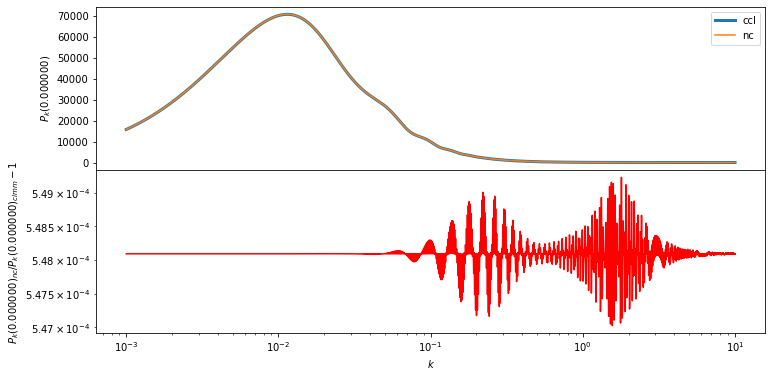

In [7]:
compare_ps (k,z[0])         # z[0] = 0.0

[P_k(0.500000)]: rel diff min: 5.769134e-04	rel diff max: 5.791198e-04


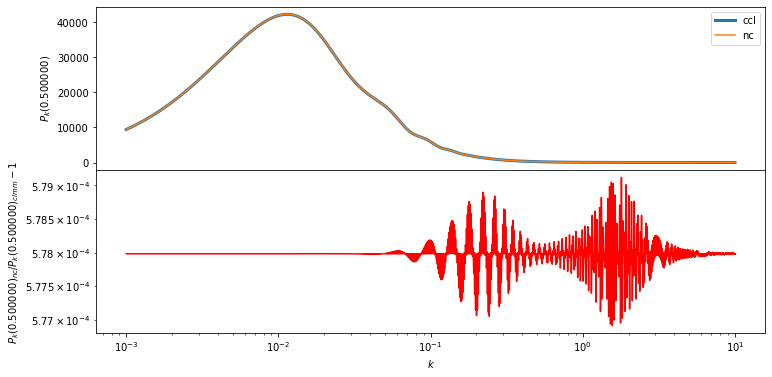

In [8]:
compare_ps (k,z[1])         # z[1] = 0.5 

[P_k(1.000000)]: rel diff min: 6.407914e-04	rel diff max: 6.429980e-04


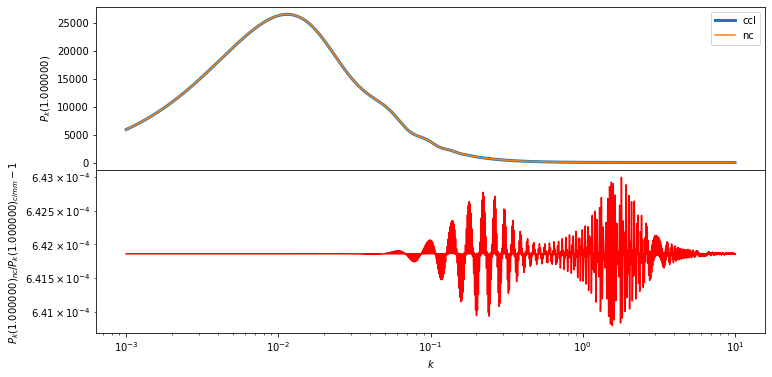

In [9]:
compare_ps (k,z[2])         # z[2] = 1.0 